**Install 🍇 by running:**

```bash
pip install grape -U
```

In [1]:
from grape.datasets.zenodo import (
    GameOfThronesCharactersInteractions
)
graph = GameOfThronesCharactersInteractions()

We get the books one to four with a filter:

In [2]:
first_boooks = graph.filter_from_names(
    edge_type_names_to_remove=["5"],
)

We get the fifth book with a filter

In [3]:
fifth_book = graph.filter_from_names(
    edge_type_names_to_keep=["5"],
)

But we are only interested in interactions
EXCLUSIVELY from the fifth book.

In [4]:
exclusively_fifth_book = (
    fifth_book - first_boooks
)

We need to remove characters that only
appear in the fifth book, as there is no
hope to predict them.

In [5]:
disconnected = first_boooks\
    .get_singleton_node_names()
first_boooks = first_boooks\
    .remove_disconnected_nodes()
exclusively_fifth_book = exclusively_fifth_book\
    .filter_from_names(
        node_names_to_remove=disconnected
    )

We also sample a negative graph to evaluate the performance

In [6]:
negative_graph = first_boooks\
    .sample_negative_graph(
        number_of_negative_samples=exclusively_fifth_book\
            .get_number_of_directed_edges(),
        use_scale_free_distribution=True
    )

*We use scale free distribution for the sampling so to avoid degree biases.*

We computer a First-order LINE embedding

In [7]:
%%time
from grape.embedders import FirstOrderLINEEnsmallen

embedding = FirstOrderLINEEnsmallen(epochs=1000)\
    .fit_transform(first_boooks)

CPU times: user 8.88 s, sys: 371 ms, total: 9.25 s
Wall time: 428 ms


We create a simple percepron model, trained on the cosine similarity of the embedding.

In [8]:
from grape.edge_prediction import PerceptronEdgePrediction

model = PerceptronEdgePrediction(
    edge_features=None,
    edge_embeddings=[
        "CosineSimilarity"
    ],
    number_of_edges_per_mini_batch=8
)

We fit the model on the first books graph

In [9]:
model.fit(
    first_boooks,
    node_features=embedding
)

We get the predictions for the fifth book

In [10]:
pred = model.predict_proba(
    exclusively_fifth_book,
    node_features=embedding,
    return_predictions_dataframe=True
).sort_values("predictions")

In [11]:
pred

,predictions,sources,destinations
17,0.012444,Jon Snow,Sansa Stark
11,0.012444,Sansa Stark,Jon Snow
450,0.021575,Arya Stark,Melisandre
583,0.021575,Melisandre,Arya Stark
87,0.023964,Jeyne Poole,Theon Greyjoy
...,...,...,...
285,0.956905,Rakharo,Aggo
387,0.957030,Aggo,Jhogo
100,0.957030,Jhogo,Aggo
91,0.957141,Jhiqui,Irri


We get the predictions for non-existent edges

In [12]:
not_pred = model.predict_proba(
    negative_graph,
    node_features=embedding,
    return_predictions_dataframe=True
).sort_values("predictions")

In [13]:
not_pred

,predictions,sources,destinations
318,0.005268,Tywin Lannister,Jeor Mormont
52,0.005268,Jeor Mormont,Tywin Lannister
61,0.006267,Jon Snow,Kevan Lannister
243,0.006267,Kevan Lannister,Jon Snow
1290,0.006709,Jarl,Tywin Lannister
...,...,...,...
1060,0.912646,Osfryd Kettleblack,Dorcas
588,0.922272,Walder Frey,Marq Piper
477,0.922272,Marq Piper,Walder Frey
1162,0.944363,Pono,Aggo


We  plot the predictions

In [14]:
import matplotlib.pyplot as plt

def plot_predictions(pred, not_pred):
    fig, ax = plt.subplots(figsize=(5, 5))

    ax.hist(
        [not_pred.predictions, pred.predictions],
        label=("Non-existing", "Fifth book only"),
        bins=30,
    )
    ax.set_xlabel("Prediction score")
    ax.set_ylabel("Prediction counts")
    ax.set_title("Predictions")
    _ = ax.legend()

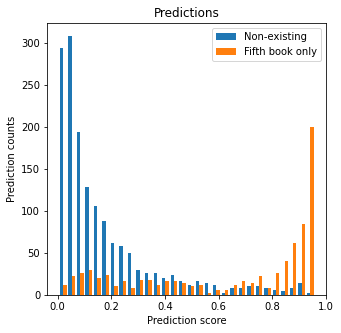

In [15]:
plot_predictions(pred, not_pred)